<a href="https://colab.research.google.com/github/mjxxkxx/Movie-Dataset_Analysis_Project/blob/main/Movie_dataset_EDA_MJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

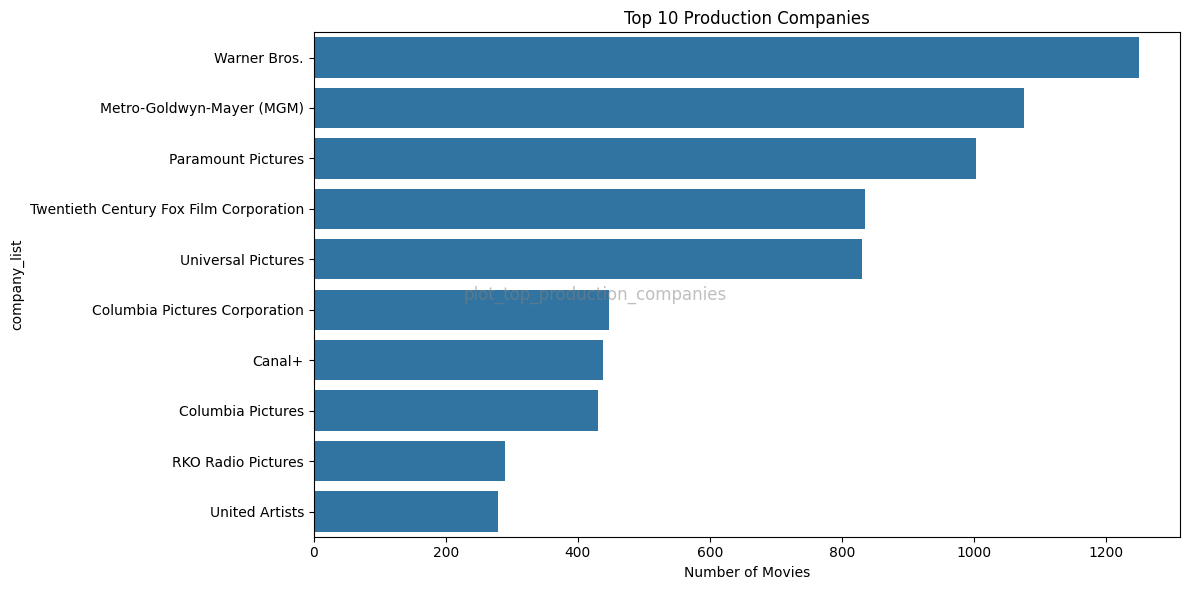

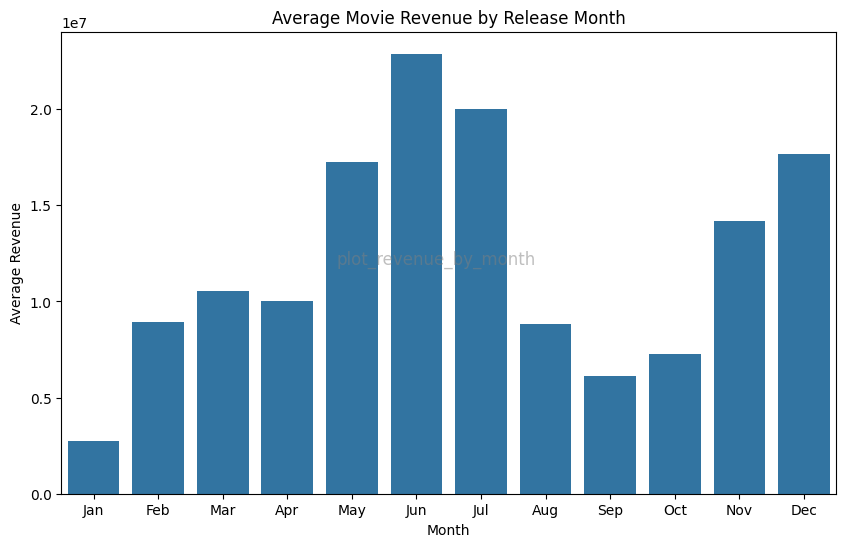

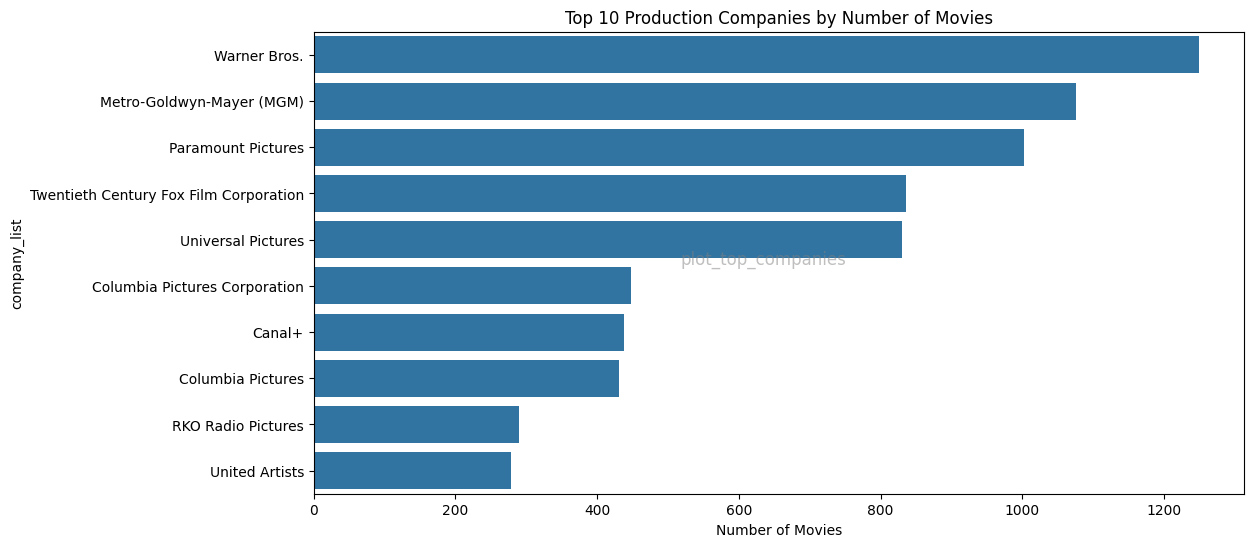

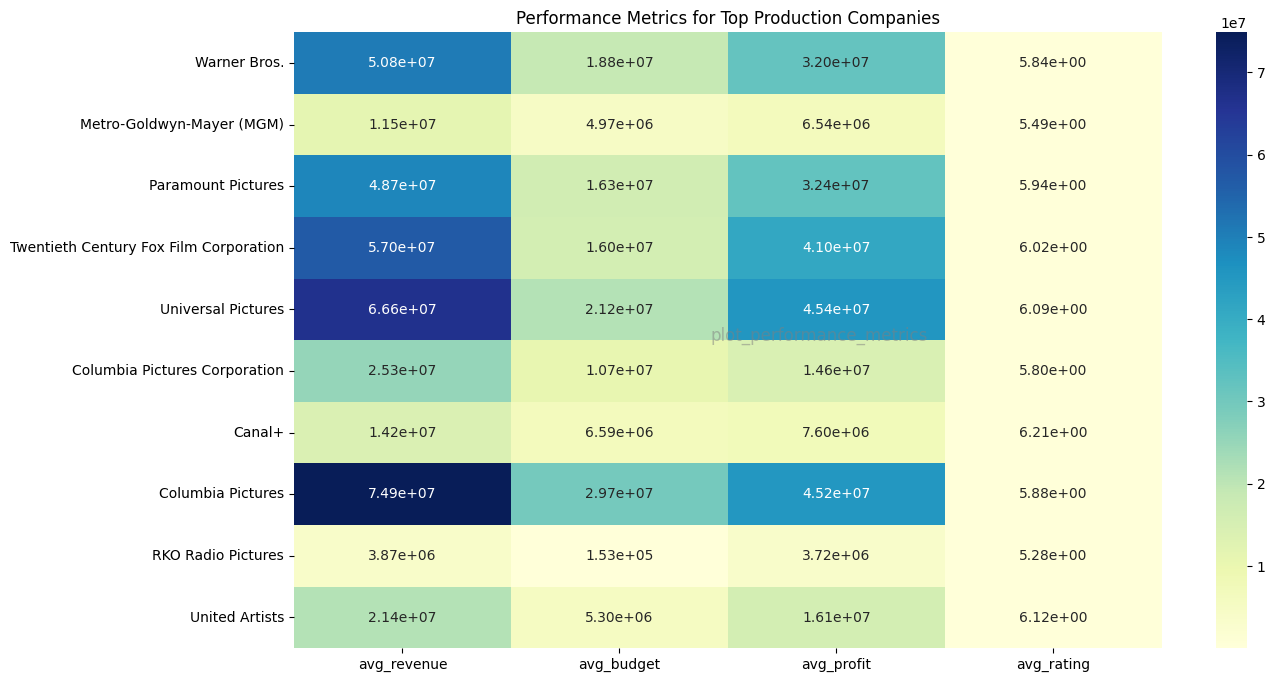

<Figure size 1400x800 with 0 Axes>

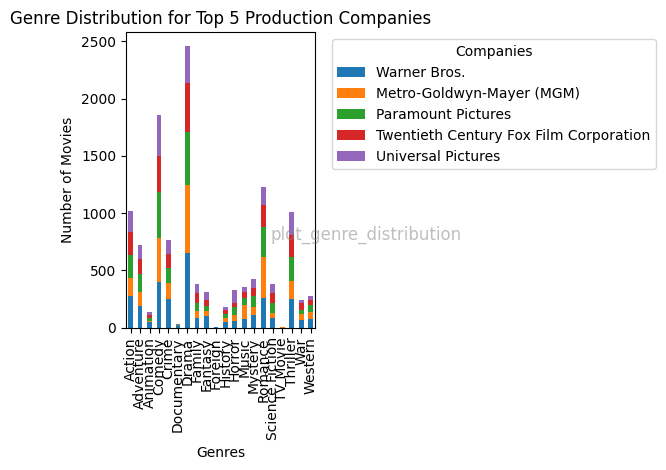

<Figure size 1400x800 with 0 Axes>

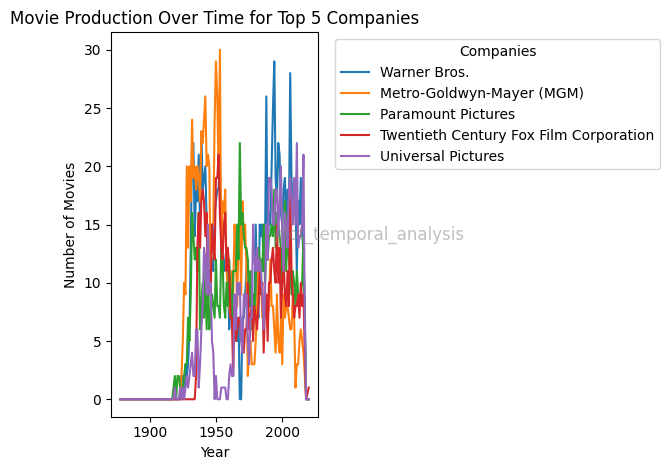

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# File paths
credits_path = '/content/drive/MyDrive/dataset_miniproject/credits.csv'
keywords_path = '/content/drive/MyDrive/dataset_miniproject/keywords.csv'
links_path = '/content/drive/MyDrive/dataset_miniproject/links.csv'
movies_metadata_path = '/content/drive/MyDrive/dataset_miniproject/movies_metadata.csv'
ratings_path = '/content/drive/MyDrive/dataset_miniproject/ratings.csv'

# Data Loading
movies_metadata_df = pd.read_csv(movies_metadata_path, low_memory=False)
ratings_df = pd.read_csv(ratings_path)
credits_df = pd.read_csv(credits_path)
keywords_df = pd.read_csv(keywords_path)
links_df = pd.read_csv(links_path)

# Data Cleaning and Preparation
movies_metadata_df['release_date'] = pd.to_datetime(movies_metadata_df['release_date'], errors='coerce')
movies_metadata_df['release_year'] = movies_metadata_df['release_date'].dt.year
movies_metadata_df['release_month'] = movies_metadata_df['release_date'].dt.month
movies_metadata_df['budget'] = pd.to_numeric(movies_metadata_df['budget'], errors='coerce')
movies_metadata_df['revenue'] = pd.to_numeric(movies_metadata_df['revenue'], errors='coerce')
movies_metadata_df['popularity'] = pd.to_numeric(movies_metadata_df['popularity'], errors='coerce')

# Helper function to extract company names and genres
def extract_company_names(x):
    if pd.isna(x):
        return []
    try:
        companies = ast.literal_eval(x)
        if isinstance(companies, list):
            return [company['name'] for company in companies if isinstance(company, dict) and 'name' in company]
        else:
            return []
    except:
        return []

def extract_genres(genre_list):
    if isinstance(genre_list, str):
        try:
            genres = ast.literal_eval(genre_list)
            return [genre['name'] for genre in genres]
        except:
            return []
    return []

movies_metadata_df['genres_list'] = movies_metadata_df['genres'].apply(extract_genres)
movies_metadata_df['company_list'] = movies_metadata_df['production_companies'].apply(extract_company_names)

# Helper function to display function name on plots
def add_function_name_on_plot(func_name):
    plt.text(0.5, 0.5, func_name, fontsize=12, color='gray',
             ha='center', va='center', alpha=0.5, transform=plt.gcf().transFigure)

# Analysis and Visualization Functions
def plot_top_production_companies():
    company_names = movies_metadata_df['company_list'].explode().value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=company_names.values, y=company_names.index)
    plt.title('Top 10 Production Companies')
    plt.xlabel('Number of Movies')
    plt.tight_layout()
    add_function_name_on_plot('plot_top_production_companies')
    plt.show()

def plot_revenue_by_month():
    monthly_revenue = movies_metadata_df.groupby('release_month')['revenue'].mean()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=monthly_revenue.index, y=monthly_revenue.values)
    plt.title('Average Movie Revenue by Release Month')
    plt.xlabel('Month')
    plt.ylabel('Average Revenue')
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    add_function_name_on_plot('plot_revenue_by_month')
    plt.show()

def plot_top_companies():
    company_counts = movies_metadata_df['company_list'].explode().value_counts()
    top_companies = company_counts.head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_companies.values, y=top_companies.index)
    plt.title('Top 10 Production Companies by Number of Movies')
    plt.xlabel('Number of Movies')
    add_function_name_on_plot('plot_top_companies')
    plt.show()

def plot_performance_metrics():
    top_companies = movies_metadata_df['company_list'].explode().value_counts().head(10)
    top_company_performance = {company: company_performance(company) for company in top_companies.index}
    performance_df = pd.DataFrame(top_company_performance).T
    plt.figure(figsize=(14, 8))
    sns.heatmap(performance_df, annot=True, fmt='.2e', cmap='YlGnBu')
    plt.title('Performance Metrics for Top Production Companies')
    add_function_name_on_plot('plot_performance_metrics')
    plt.show()

def company_performance(company):
    company_movies = movies_metadata_df[movies_metadata_df['company_list'].apply(lambda x: company in x if isinstance(x, list) else False)]
    return {
        'avg_revenue': company_movies['revenue'].mean(),
        'avg_budget': company_movies['budget'].mean(),
        'avg_profit': (company_movies['revenue'] - company_movies['budget']).mean(),
        'avg_rating': company_movies['vote_average'].mean()
    }

def plot_genre_distribution():
    top_companies = movies_metadata_df['company_list'].explode().value_counts().head(10)
    company_genre_dist = {company: company_genres(company) for company in top_companies.index[:5]}  # Top 5 for brevity
    genre_df = pd.DataFrame(company_genre_dist).fillna(0)
    plt.figure(figsize=(14, 8))
    genre_df.plot(kind='bar', stacked=True)
    plt.title('Genre Distribution for Top 5 Production Companies')
    plt.xlabel('Genres')
    plt.ylabel('Number of Movies')
    plt.legend(title='Companies', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    add_function_name_on_plot('plot_genre_distribution')
    plt.show()

def company_genres(company):
    company_movies = movies_metadata_df[movies_metadata_df['company_list'].apply(lambda x: company in x if isinstance(x, list) else False)]
    genres = [genre for genres in company_movies['genres_list'] for genre in genres if isinstance(genres, list)]
    return pd.Series(genres).value_counts()

def plot_temporal_analysis():
    top_companies = movies_metadata_df['company_list'].explode().value_counts().head(10)
    company_years = movies_metadata_df.explode('company_list')[['release_year', 'company_list']]
    company_production_over_time = company_years.groupby(['release_year', 'company_list']).size().unstack(fill_value=0)
    plt.figure(figsize=(14, 8))
    company_production_over_time[top_companies.index[:5]].plot(kind='line')  # Top 5 companies
    plt.title('Movie Production Over Time for Top 5 Companies')
    plt.xlabel('Year')
    plt.ylabel('Number of Movies')
    plt.legend(title='Companies', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    add_function_name_on_plot('plot_temporal_analysis')
    plt.show()

# Main execution
if __name__ == "__main__":
    plot_top_production_companies()
    plot_revenue_by_month()
    plot_top_companies()
    plot_performance_metrics()
    plot_genre_distribution()
    plot_temporal_analysis()
